In [2]:
import re
import json
import pandas as pd
import numpy as np
import seaborn
import io
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
# just set the seed for the random number generator
np.random.seed(107)

In [4]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [13]:
prices_df = pd.read_csv("../past_data/combined_coconut_coupon_prices.csv")
prices_df_0 = prices_df.iloc[:10000]
prices_df_1 = prices_df.iloc[10000:20000]
prices_df_2 = prices_df.iloc[20000:30000]

[[1.00000000e+00 7.05583998e-07]
 [1.00000000e+00 1.00000000e+00]]


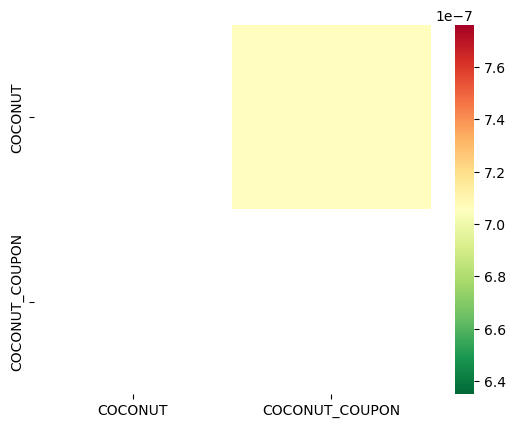

In [36]:
scores, pvalues, pairs = find_cointegrated_pairs(prices_df)
products = ["COCONUT", "COCONUT_COUPON"]
seaborn.heatmap(pvalues, xticklabels=products, yticklabels=products, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print(pvalues)

In [42]:
S1 = prices_df['COCONUT_COUPON']
S2 = prices_df['COCONUT']
score, pvalue, _ = coint(S1, S2)
print (score)

-6.440746508016365


1.8245903445270337


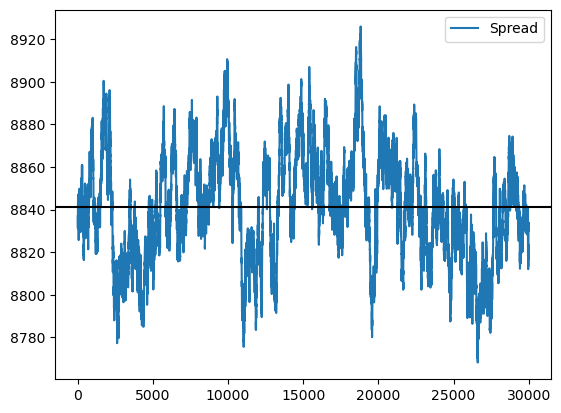

In [43]:
#spread
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['COCONUT_COUPON']
b = results.params['COCONUT_COUPON']

spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])
print(b)

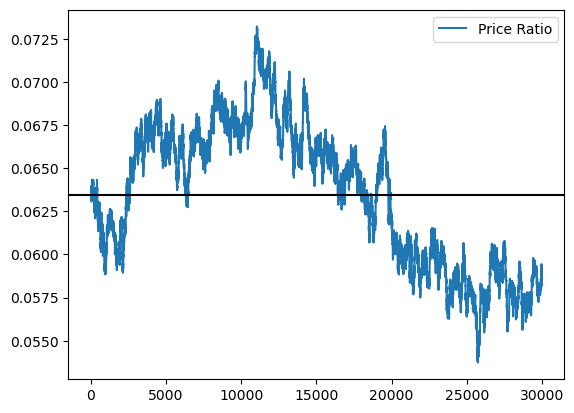

In [39]:
ratio = S1/S2
ratio.plot()
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio']);

In [40]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

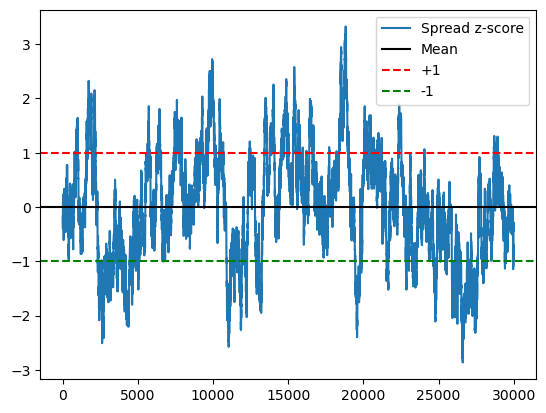

In [41]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

In [35]:
# Get the spread between the 2 stocks
# Calculate rolling beta coefficient
rolling_beta = pd.ols(y=S1, x=S2, window_type='rolling', window=30)
spread = S2 - rolling_beta.beta['x'] * S1
spread.name = 'spread'

# Get the 1 day moving average of the price spread
spread_mavg1 = pd.rolling_mean(spread, window=1)
spread_mavg1.name = 'spread 1d mavg'

# Get the 30 day moving average
spread_mavg30 = pd.rolling_mean(spread, window=30)
spread_mavg30.name = 'spread 30d mavg'

plt.plot(spread_mavg1.index, spread_mavg1.values)
plt.plot(spread_mavg30.index, spread_mavg30.values)

plt.legend(['1 Day Spread MAVG', '30 Day Spread MAVG'])

plt.ylabel('Spread')

AttributeError: module 'pandas' has no attribute 'ols'